In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import warnings 
warnings.filterwarnings('ignore')

In [2]:
scores = pd.read_csv('data/historical_round_scores.csv')
year = 2021
tourney_name = 'bmw_championship'

pre_tourney = pd.read_csv(f'data/{year}_{tourney_name}_pre_tourney_snapshot.csv')

In [3]:
early_outs = ['CUT','DQ','WD', 'W/D', 'MDF',]
early_out_default = 75

scores['early_out'] = np.where(scores.fin_text.isin(early_outs), 1, 0)
scores['fin_num'] = (np.where(scores.fin_text.isin(early_outs),
                             early_out_default,
                             scores.fin_text.str.replace('T',''))
                    ).astype(int)

scores['year_event_id'] = scores['year'].astype(str) + '_' + scores['event_id'].astype(str)
max_fin_dict = scores.groupby('year_event_id')['fin_num'].max().to_dict()

scores['fin_num'] = np.where(scores.fin_text.isin(early_outs),
                             scores.year_event_id.map(max_fin_dict),
                             scores.fin_num)

In [4]:
scores['year_event_golfer'] = (scores['year'].astype(str) +
                                      '_' + scores['event_id'].astype(str) +
                                      '_' + scores['dg_id'].astype(str)
                              )

# Aggregating round data to an event level
event_df = (scores.groupby(['dg_id','player_name','event_name',
                            'event_id','fin_text','fin_num','early_out',
                            'year','year_event_id','year_event_golfer','event_completed',]).
            agg(rounds=('round','count'),
                mean_score = ('score', 'mean'),
                mean_sg = ('sg_total', 'mean'),
                total_sg = ('sg_total', 'sum')
               ).reset_index().sort_values('event_completed')
           )

majors = ['Masters Tournament','The Masters','The Masters #2','The Open Championship',
          'U.S. Open','U.S. Open #2','PGA Championship',
         ]

event_df['major'] = np.where(event_df['event_name'].isin(majors), 1, 0)

event_df['won_major'] = np.where((event_df['major'] == 1) & (event_df.fin_num == 1), 1, 0)

event_df['top_10'] = np.where(event_df['fin_num'] <= 10, 1, 0)

In [5]:
def create_rolling_agg_features_by_golfer(df, field, n_shift, n_rolling, agg_func):
    """
    """
    df = df.copy()
    
    df['shifted_field'] = (df.groupby('dg_id')[field]
                           .shift(n_shift)
                           .fillna(0)
                          )
    
    return (df.groupby('dg_id')['shifted_field']
            .transform(lambda x: x.rolling(n_rolling, min_periods=1)
                       .agg(agg_func))
           )

In [6]:
metric_lst = [
    {'field': 'early_out','periods': [2, 5], 'agg': 'sum'},
    {'field': 'fin_num', 'periods': [2, 5], 'agg': 'mean'},
    {'field': 'mean_sg', 'periods': [2, 5], 'agg':'mean'},
    {'field': 'won_major', 'periods': [50], 'agg':'sum'},
    {'field': 'top_10', 'periods': [10, 20], 'agg': 'sum'},
    ]


In [7]:
for metric in metric_lst:
    field = metric.get('field')
    agg = metric.get('agg')
    for period in metric.get('periods'):
        col = f"{field}_in_prev_{period}_events"
        event_df[col] = create_rolling_agg_features_by_golfer(event_df, field, 1, period, agg)

In [8]:
event_df.head()

,dg_id,player_name,event_name,event_id,fin_text,fin_num,early_out,year,year_event_id,year_event_golfer,event_completed,rounds,mean_score,mean_sg,total_sg,major,won_major,top_10,early_out_in_prev_2_events,early_out_in_prev_5_events,fin_num_in_prev_2_events,fin_num_in_prev_5_events,mean_sg_in_prev_2_events,mean_sg_in_prev_5_events,won_major_in_prev_50_events,top_10_in_prev_10_events,top_10_in_prev_20_events
16477,14139,"Thomas, Justin",SBS Tournament of Champions,16,1,1,0,2017,2017_16,2017_16_14139,2017-01-08,4,67.50,2.87525,11.501,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642,5668,"Pampling, Rod",SBS Tournament of Champions,16,T17,17,0,2017,2017_16,2017_16_5668,2017-01-08,4,70.25,0.12525,0.501,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5376,7489,"Moore, Ryan",SBS Tournament of Champions,16,T3,3,0,2017,2017_16,2017_16_7489,2017-01-08,4,69.00,1.37525,5.501,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7856,8571,"Gomez, Fabian",SBS Tournament of Champions,16,20,20,0,2017,2017_16,2017_16_8571,2017-01-08,4,70.50,-0.12475,-0.499,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1968,5768,"Hoffman, Charley",SBS Tournament of Champions,16,T17,17,0,2017,2017_16,2017_16_5768,2017-01-08,4,70.25,0.12525,0.501,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis

In [9]:
feat_cols = [
    'early_out_in_prev_2_events',
    'early_out_in_prev_5_events',
    'fin_num_in_prev_2_events',
    'fin_num_in_prev_5_events',
    'mean_sg_in_prev_2_events', 
    'mean_sg_in_prev_5_events',
    'won_major_in_prev_50_events',
    'top_10_in_prev_10_events',
    'top_10_in_prev_20_events',
]

target_col = 'total_sg'

In [10]:
event_df[feat_cols + [target_col]].corr().loc[target_col]

early_out_in_prev_2_events    -0.146771
early_out_in_prev_5_events    -0.146362
fin_num_in_prev_2_events      -0.122712
fin_num_in_prev_5_events      -0.113740
mean_sg_in_prev_2_events       0.245487
mean_sg_in_prev_5_events       0.288940
won_major_in_prev_50_events    0.070869
top_10_in_prev_10_events       0.258298
top_10_in_prev_20_events       0.275702
total_sg                       1.000000
Name: total_sg, dtype: float64

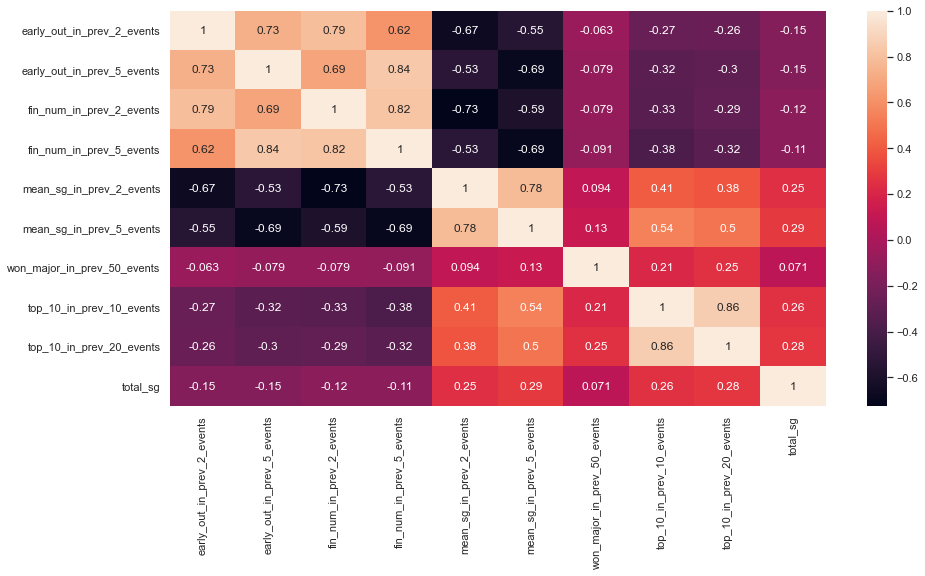

In [11]:
sns.set(rc={'figure.figsize':(14.7,7.27)})
c = event_df[feat_cols + [target_col]].corr()
sns.heatmap(c, annot=True)

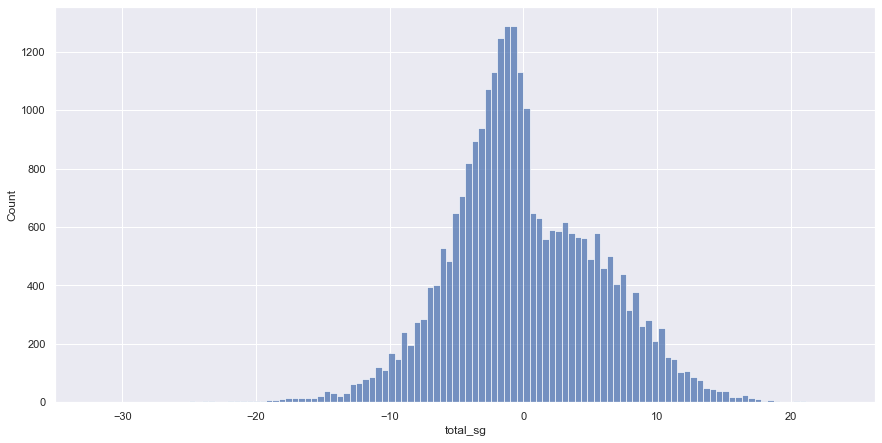

In [12]:
sns.histplot(data=event_df, x="total_sg")

### Training

In [13]:
early_events_to_filter = event_df.sort_values('event_completed')['year_event_id'].unique()[0:11]
event_df = event_df.loc[~event_df.year_event_id.isin(early_events_to_filter)]

In [14]:
X = event_df[feat_cols]

y = event_df['total_sg']

In [15]:
from sklearn.linear_model import LinearRegression

# Fitting the model
lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
r2 = lr.score(X, y)
print('R^2: {0}'.format(r2))

R^2: 0.12790178989803713


In [17]:
from statsmodels.api import OLS

lr = OLS(y, X).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:               total_sg   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     341.0
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:50:14   Log-Likelihood:                -79195.
No. Observations:               25611   AIC:                         1.584e+05
Df Residuals:                   25602   BIC:                         1.585e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
early_out_in_prev_

In [18]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [19]:
calculate_residuals(lr, X, y).sort_values('Predicted', ascending=False)

,Actual,Predicted,Residuals
9226,12.014,9.367156,2.646844
9157,9.609,9.299767,0.309233
24144,12.794,9.220251,3.573749
9191,-0.699,9.087505,-8.388505
9196,8.972,9.057291,-0.085291
...,...,...,...
23544,-13.279,-7.455148,5.823852
23570,-7.650,-7.583560,0.066440
23586,-1.041,-7.638952,-6.597952
564,-25.009,-8.307260,16.701740


In [20]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


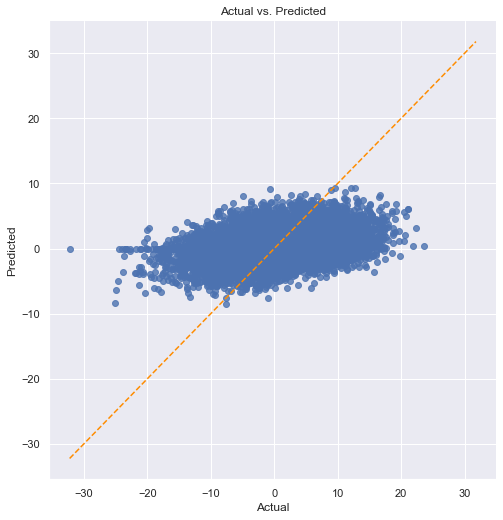

In [21]:
linear_assumption(lr, X, y);

In [22]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


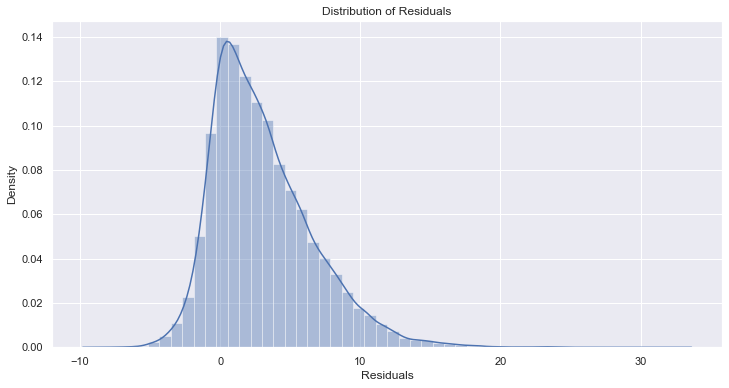


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [23]:
normal_errors_assumption(lr, X, y, p_value_thresh=0.05)

In [36]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Assumption 3: Little to no multicollinearity among predictors


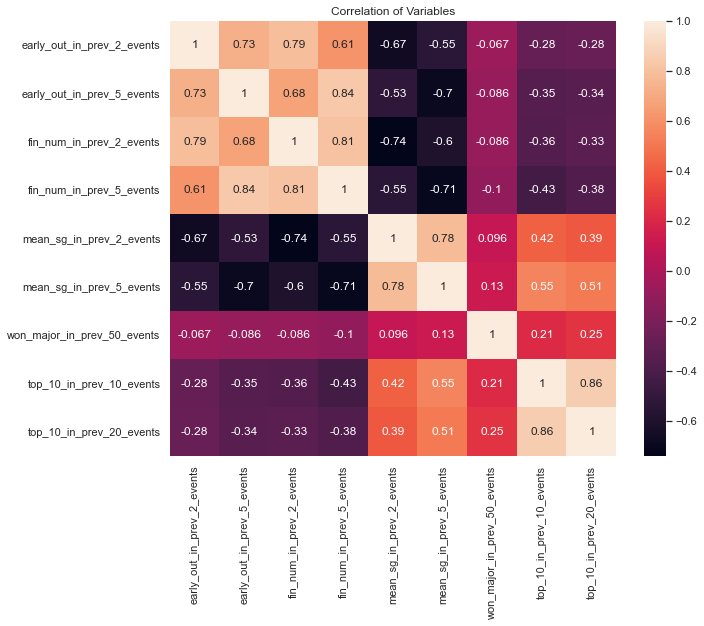

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
early_out_in_prev_2_events: 10.677125013820485
early_out_in_prev_5_events: 17.737509805014078
fin_num_in_prev_2_events: 61.81345377887116
fin_num_in_prev_5_events: 68.29128743954563
mean_sg_in_prev_2_events: 6.460525671394584
mean_sg_in_prev_5_events: 6.442948108457119
won_major_in_prev_50_events: 1.0840660254542633
top_10_in_prev_10_events: 6.205660709398596
top_10_in_prev_20_events: 6.562569606321822

4 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [37]:
multicollinearity_assumption(lr, X, y, feature_names=X.columns)

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


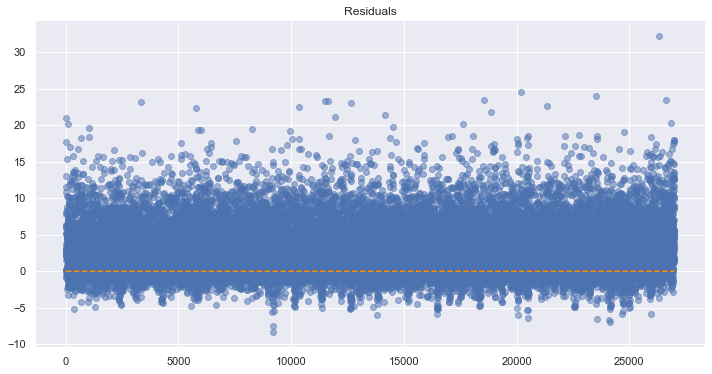

In [39]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()
    
homoscedasticity_assumption(lr, X, y)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
rf = RandomForestRegressor( n_estimators=1000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
preds = rf.predict(X_test)

In [ ]:
mean_absolute_error(y_test, preds)

In [ ]:
preds.max()

## Make predictions

In [ ]:
player_field = pre_tourney['dg_id'].unique()

In [ ]:
new_event_df = event_df.append(pre_tourney[['dg_id', 'player_name','event_name',]], sort=False)
new_event_df['major'] = np.where(new_event_df.event_name.isin(majors), 1, 0)

In [ ]:
for metric in metric_lst:
    field = metric.get('field')
    agg = metric.get('agg')
    for period in metric.get('periods'):
        col = f"{field}_in_prev_{period}_events"
        new_event_df[col] = create_rolling_agg_features_by_golfer(new_event_df, field, 1, period, agg)

In [ ]:
new_event_df = new_event_df.loc[pd.isnull(new_event_df.fin_num)]
X_te = new_event_df[feat_cols]

In [ ]:
X_te.shape

In [ ]:
rf.predict(X_te)

In [ ]:
new_event_df['preds'] = rf.predict(X_te)

In [ ]:
new_event_df['rank'] = new_event_df['preds'].rank()

In [ ]:
new_event_df.sort_values('rank').head(10)

In [42]:
scores.query("year_event_id == '2019_518'")

,course_name,course_num,dg_id,event_completed,event_id,event_name,fin_text,player_name,round,score,sg_app,sg_arg,sg_ott,sg_putt,sg_t2g,sg_total,year,early_out,fin_num,year_event_id,year_event_golfer
35665,Keene Trace Golf Club,884,12846,2019-07-21,518,Barbasol Championship,1,"Herman, Jim",round_1,65,1.913,0.267,0.577,2.395,2.757,5.152,2019,0,1,2019_518,2019_518_12846
35666,Keene Trace Golf Club,884,12846,2019-07-21,518,Barbasol Championship,1,"Herman, Jim",round_2,65,0.721,0.416,-0.753,4.127,0.384,4.511,2019,0,1,2019_518,2019_518_12846
35667,Keene Trace Golf Club,884,12846,2019-07-21,518,Barbasol Championship,1,"Herman, Jim",round_3,62,2.171,-0.330,1.908,3.454,3.749,7.203,2019,0,1,2019_518,2019_518_12846
35668,Keene Trace Golf Club,884,12846,2019-07-21,518,Barbasol Championship,1,"Herman, Jim",round_4,70,-1.159,1.096,1.024,-1.836,0.961,-0.875,2019,0,1,2019_518,2019_518_12846
35669,Keene Trace Golf Club,884,15852,2019-07-21,518,Barbasol Championship,2,"Kraft, Kelly",round_1,65,0.924,0.237,1.290,2.701,2.451,5.152,2019,0,2,2019_518,2019_518_15852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36074,Keene Trace Golf Club,884,7470,2019-07-21,518,Barbasol Championship,MDF,"MacKenzie, Will",round_2,69,0.533,0.529,-1.903,1.352,-0.841,0.511,2019,1,75,2019_518,2019_518_7470
36075,Keene Trace Golf Club,884,7470,2019-07-21,518,Barbasol Championship,MDF,"MacKenzie, Will",round_3,79,-2.320,-0.268,0.082,-7.291,-2.506,-9.797,2019,1,75,2019_518,2019_518_7470
36076,Keene Trace Golf Club,884,7927,2019-07-21,518,Barbasol Championship,MDF,"Wagner, Johnson",round_1,69,0.518,0.541,-0.177,0.270,0.882,1.152,2019,1,75,2019_518,2019_518_7927
36077,Keene Trace Golf Club,884,7927,2019-07-21,518,Barbasol Championship,MDF,"Wagner, Johnson",round_2,71,-0.513,-0.287,-0.706,0.017,-1.506,-1.489,2019,1,75,2019_518,2019_518_7927
